In [1]:
import os
import sys
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch

module_path = os.path.abspath(os.path.join('../chemical_properties_predictor'))
if module_path not in sys.path:
    sys.path.append(module_path)
import models
import data_utils as data

%matplotlib inline
%load_ext autoreload

torch.manual_seed(28)

In [2]:
chembl_path = '../data/ChEMBL_subset.csv'
# chembl_path = './ChEMBL_subset.csv'

df = pd.read_csv(chembl_path, delimiter = ';')

#drop all rows with a nan in the 3 columns of interest
mols_df = df['Smiles'].replace('None', np.nan)
mols_df = mols_df.dropna()
mols_df = mols_df.astype({'Smiles':str})

#filter out molecules with SMILES strings longer than 250
mols_df = mols_df[mols_df.str.len() <= 250]

#Take every 10th sample to create toy dataset
print(mols_df.shape)
mols_df = mols_df.iloc[lambda x: x.index % 10 == 0]
print(mols_df.shape)
mols_df.head()

C:\Users\tatum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (32,33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(243326,)
(24313,)


0                          O=c1oc(SCc2ccccc2)nc2ccccc12
10     [N-]=[N+]=N[C@H]1C[C@H]2O[C@@H]1COC1NC(=O)C=CN12
20    CCN1C[C@]2(OC(=O)c3ccccc3NC(C)=O)CC[C@H](OC)[C...
30    Cl.Cn1cc(NC(=O)Cn2ccnc2[N+](=O)[O-])cc1C(=O)NC...
40    CC(=O)c1cccc(NC(=O)N[C@@H]2CCCC[C@H]2CN2CCC[C@...
Name: Smiles, dtype: object

In [3]:
#load CHAR_DICT and CHAR_WEIGHTS

with open('../data/CHAR_DICT.json', 'r') as f:
# with open('./CHAR_DICT.json', 'r') as f:
    char_dict = json.load(f)
    f.close()
    
char_dict['<EOS>'] = 144
    
char_weights = np.load('../data/CHAR_WEIGHTS.pickle.npy', allow_pickle = True)
# char_weights = np.load('./CHAR_WEIGHTS.pickle.npy', allow_pickle = True)
char_weights = torch.from_numpy(char_weights)
char_weights = char_weights.type(torch.float)
print(char_weights.size())

torch.Size([144])


In [4]:
%autoreload

train, test = train_test_split(mols_df)

train_dataset = data.VAEChemDataset(train, char_dict, max_length = 250)
test_dataset = data.VAEChemDataset(test, char_dict, max_length = 250)

batchsize = 256

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batchsize,
                                           shuffle = True, num_workers = 2,
                                           drop_last = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batchsize,
                                          shuffle = True, num_workers = 2,
                                          drop_last = True)

In [5]:
params = {
    'BATCH_SIZE': batchsize,
    'MODEL_TYPE': 'RNNAttn',
    'SAVE': True,
    'LOAD': False,
    'SAVE_FREQ': 1,
    'SAVE_PATH': '../models/rnnattn_vae_model.ckpt',
#     'SAVE_PATH': './rnnattn_vae_model.ckpt',
    'N_EPOCHS': 100,
    'EMBEDDING_DIMS': 256,
    'LR': 1e-5,
    'BETA_INIT': 1e-8,
    'BETA': 0.05,
    'ANNEAL_START': 0,
    'CHAR_WEIGHTS': char_weights,
    'CHAR_DICT': char_dict,
    'MAX_LENGTH': 250
}

C:\Users\tatum\Anaconda3\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


C:\Users\tatum\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           #       1.00      1.00      1.00      1350
           %       0.79      0.99      0.88        96
           (       1.00      1.00      1.00    104474
           )       1.00      1.00      1.00    104474
           *       1.00      1.00      1.00   3468486
           +       1.00      1.00      1.00      1463
           -       1.00      1.00      1.00      8038
           .       1.00      1.00      1.00      1448
           /       1.00      1.00      1.00      4576
           1       1.00      1.00      1.00     50059
          10       1.00      0.57      0.73        14
          11       1.00      1.00      1.00       106
          12       1.00      1.00      1.00      1917
         123       1.00      0.86      0.92        14
         124       0.00      0.00      0.00         3
         125       1.00      1.00      1.00        81
         127       0.00      0.00      0.00         1
          13       1.00    

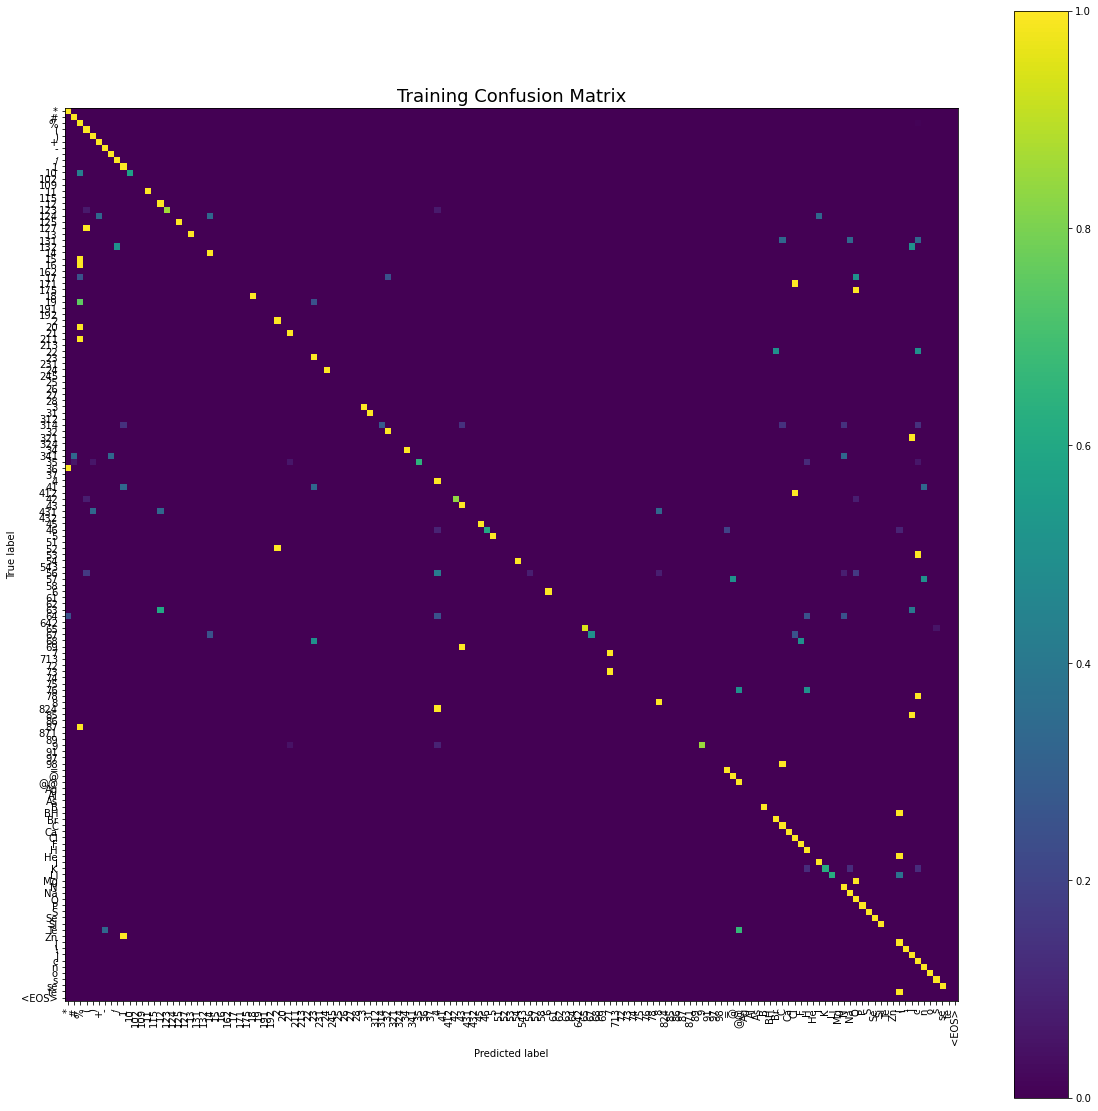

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:79] data. DefaultCPUAllocator: not enough memory: you tried to allocate 262144 bytes.

In [6]:
%autoreload

model = models.RNNAttnVAE(params = params, N = 3, d_model = params['EMBEDDING_DIMS'],
                          d_latent = 128, dropout = 0.1, teacher_force = True)
#for when track_tokens = True (default)
train_epoch_losses, test_epoch_losses, train_epoch_accuracies, test_epoch_accuracies, token_tracker = model.train_test_epochs(train_loader, test_loader)

#for when track_tokens = False
# train_epoch_losses, test_epoch_losses, train_epoch_accuracies, test_epoch_accuracies = model.train_test_epochs(train_loader, test_loader, track_tokens = False)

In [7]:
total_train_loss = [x[0] for x in train_epoch_losses]
bce_train_loss = [x[1] for x in train_epoch_losses]
kld_train_loss = [x[2] for x in train_epoch_losses]

total_test_loss = [x[0] for x in test_epoch_losses]
bce_test_loss = [x[1] for x in test_epoch_losses]
kld_test_loss = [x[2] for x in test_epoch_losses]

smiles_train_acc = [x[0] for x in train_epoch_accuracies]
token_train_acc = [x[1] for x in train_epoch_accuracies]
position_train_acc = [x[2] for x in train_epoch_accuracies]

smiles_test_acc = [x[0] for x in test_epoch_accuracies]
token_test_acc = [x[1] for x in test_epoch_accuracies]
position_test_acc = [x[2] for x in test_epoch_accuracies]

NameError: name 'train_epoch_losses' is not defined

In [ ]:
position_train_acc = np.array(position_train_acc)
avg_position_train_acc = np.mean(position_train_acc, axis = 0)

position_test_acc = np.array(position_test_acc)
avg_position_test_acc = np.mean(position_test_acc, axis = 0)

In [ ]:
#define plt.rcparams
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Arial'
plt.rc('axes', labelsize = 18)
plt.rc('xtick', labelsize = 12)
plt.rc('ytick', labelsize = 16)
plt.rc('legend', fontsize = 12)

#losses per epoch
epochs = range(0, len(total_train_loss))
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(epochs, total_train_loss, c = 'k', linestyle = 'dashdot', label = 'total train')
ax.plot(epochs, bce_train_loss, c = 'r', linestyle = 'dashdot', label = 'bce train')
ax.plot(epochs, kld_train_loss, c = 'c', linestyle = 'dashdot', label = 'kld train')
ax.plot(epochs, total_test_loss, c = 'k', linestyle = 'solid', label = 'total test')
ax.plot(epochs, bce_test_loss, c = 'r', linestyle = 'solid', label = 'bce test')
ax.plot(epochs, kld_test_loss, c = 'c', linestyle = 'solid', label = 'kld train')
ax.set_title('Loss per Epoch', fontsize = 18)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.legend()
plt.show()

#accuracies per epoch (position needs to be separately plotted)
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(epochs, smiles_train_acc, c = 'k', linestyle = 'dashdot', label = 'smiles train')
ax.plot(epochs, token_train_acc, c = 'r', linestyle = 'dashdot', label = 'token train')
ax.plot(epochs, smiles_test_acc, c = 'k', linestyle = 'solid', label = 'smiles test')
ax.plot(epochs, token_test_acc, c = 'r', linestyle = 'solid', label = 'token test')
ax.set_title('Accuracy per Epoch', fontsize = 18)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy (decimal)')
plt.legend()
plt.show()

#accuracy with respect to token position (smiles length)
length = range(0, len(avg_position_train_acc))
fig, ax = plt.subplots(figsize = (12, 8))
# ax.plot(length, avg_position_train_acc, c = 'r', linestyle = 'dotted', label = 'avg train')
# ax.plot(length, avg_position_test_acc, c = 'k', linestyle = 'dotted', label = 'avg test')

train_colors = plt.cm.Greens(np.linspace(0.5, 0.9, len(total_train_loss)))
test_colors = plt.cm.Purples(np.linspace(0.5, 0.9, len(total_train_loss)))
for i in epochs:
    if i == epochs[-1]:
        ax.plot(length, position_train_acc[i], c = train_colors[i],
                linestyle = 'solid', label = 'train - epochs')
        ax.plot(length, position_test_acc[i], c = test_colors[i],
                linestyle = 'solid', label = 'test - epochs')
    else:
        ax.plot(length, position_train_acc[i], c = train_colors[i],
                linestyle = 'dashdot')
        ax.plot(length, position_test_acc[i], c = test_colors[i],
                linestyle = 'dashdot')

ax.set_xlabel('Token Position')
ax.set_ylabel('Accuracy (decimal)')
plt.title('Accuracy wrt. Token Position', fontsize = 18)
plt.legend()
plt.show()

In [ ]:
%autoreload

data.plot_token_type_accuracy_horizontal(token_tracker, last_ep_only = True)

In [10]:
%autoreload

#Need to re-structure for large training sets. Memory allocation for square dataframe is too large

#may be unnecessary now that there is a multilable confusion matrix

# data.plot_pairwise_correlation(token_tracker)

MemoryError: Unable to allocate 124. GiB for an array with shape (145, 114855404) and data type object

## TODO

#### `VAEShell`:
 
 
#### Utilities:


#### Usage:
 - Figure out how to access the trained encoder and latent space
         - Is this simply taking the latent space out-put during VAE reconstruction of the structure? If so, then a separate class isn't needed. Only a separate function that stores the encoding. This would exist in the `RNNEncoderDecoder` class
 - Create a class that loads these weights and either saves the encoded structures in a pickle file or that can be used inline for a larger property prediction network
 - When predicting properties, it may be best to train the VAE to both reconstruct the molecule and also predict the property. Even if the prediction is bad, it could force the model to identify parts of the molecules most informative to predicting that property. We should compare those two approaches (universal vs. property-specific encodings)

In [ ]:
toknzr = data.SmilesTokenizer(char_dict)

# 7837 COc1cc(CN(C[C@H]2CC[C@H](C(=O)O)CC2)C(C)c2ccc3c(c2)CCO3)ccc1OCCN1C(=O)COC1=O
# 3211 CCC(O)CNC(=O)COc1c(C)cccc1C
# 17617 CCCSc1ccc2nc(NC(=O)OC)[nH]c2c1
# 841 NC1=CC(=O)c2ccc(C=O)nc2C1=O
# 5463 COc1ccc(-c2ccc3ncnc(-c4cncc(C(=O)N5CCN(C)CC5)c4)c3c2)cn1
# 18079 CC1OC(c2nc3c([N+](=O)[O-])cccn3n2)C(O)C(O)C1=O

smiles = 'CC1OC(c2nc3c([N+](=O)[O-])cccn3n2)C(O)C(O)C1=O'

tok_list, ind_list = toknzr.tokenize(smiles)

In [ ]:
tok_list

['C',
 'C',
 '1',
 'O',
 'C',
 '(',
 'c',
 '2',
 'n',
 'c',
 '3',
 'c',
 '(',
 '[',
 'N',
 '+',
 ']',
 '(',
 '=',
 'O',
 ')',
 '[',
 'O',
 '-',
 ']',
 ')',
 'c',
 'c',
 'c',
 'n',
 '3',
 'n',
 '2',
 ')',
 'C',
 '(',
 'O',
 ')',
 'C',
 '(',
 'O',
 ')',
 'C',
 '1',
 '=',
 'O',
 '<EOS>']

In [61]:
test_dict = {
    1: [0,1,2],
    2: [0,2,1]
}

test_dict[1].append(5)
test_dict

{1: [0, 1, 2, 5], 2: [0, 2, 1]}